___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

This unit is divided into two sections:
* First, we'll find out what what is necessary to build an NLP system that can turn a body of text into a numerical array of *features*.
* Next we'll show how to perform these steps using real tools.

# Building a Natural Language Processor From Scratch
In this section we'll use basic Python to build a rudimentary NLP system. We'll build a *corpus of documents* (two small text files), create a *vocabulary* from all the words in both documents, and then demonstrate a *Bag of Words* technique to extract features from each document.<br>
<div class="alert alert-info" style="margin: 20px">**This first section is for illustration only!**
<br>Don't bother memorizing the code - we'd never do this in real life.</div>

## Start with some documents:
For simplicity we won't use any punctuation.

In [1]:
%%writefile 1.txt
This is a story about cats
our feline pets
Cats are furry animals

Overwriting 1.txt


In [2]:
%%writefile 2.txt
This story is about surfing
Catching waves is fun
Surfing is a popular water sport

Overwriting 2.txt


## Build a vocabulary
The goal here is to build a numerical array from all the words that appear in every document. Later we'll create instances (vectors) for each individual document.

In [3]:
vocab = {}
i = 1

with open('1.txt') as f:
    x = f.read().lower().split()

for word in x:
    if word in vocab:
        continue
    else:
        vocab[word]=i
        i+=1

print(vocab)

{'this': 1, 'is': 2, 'a': 3, 'story': 4, 'about': 5, 'cats': 6, 'our': 7, 'feline': 8, 'pets': 9, 'are': 10, 'furry': 11, 'animals': 12}


In [4]:
with open('2.txt') as f:
    x = f.read().lower().split()

for word in x:
    if word in vocab:
        continue
    else:
        vocab[word]=i
        i+=1

print(vocab)

{'this': 1, 'is': 2, 'a': 3, 'story': 4, 'about': 5, 'cats': 6, 'our': 7, 'feline': 8, 'pets': 9, 'are': 10, 'furry': 11, 'animals': 12, 'surfing': 13, 'catching': 14, 'waves': 15, 'fun': 16, 'popular': 17, 'water': 18, 'sport': 19}


Even though `2.txt` has 15 words, only 7 new words were added to the dictionary.

## Feature Extraction
Now that we've encapsulated our "entire language" in a dictionary, let's perform *feature extraction* on each of our original documents:

In [5]:
# Create an empty vector with space for each word in the vocabulary:
one = ['1.txt']+[0]*len(vocab)
one

['1.txt', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
# map the frequencies of each word in 1.txt to our vector:
with open('1.txt') as f:
    x = f.read().lower().split()
    
for word in x:
    one[vocab[word]]+=1
    
one

['1.txt', 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

<font color=green>We can see that most of the words in 1.txt appear only once, although "cats" appears twice.</font>

In [7]:
# Do the same for the second document:
two = ['2.txt']+[0]*len(vocab)

with open('2.txt') as f:
    x = f.read().lower().split()
    
for word in x:
    two[vocab[word]]+=1

In [8]:
# Compare the two vectors:
print(f'{one}\n{two}')

['1.txt', 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
['2.txt', 1, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1]


By comparing the vectors we see that some words are common to both, some appear only in `1.txt`, others only in `2.txt`. Extending this logic to tens of thousands of documents, we would see the vocabulary dictionary grow to hundreds of thousands of words. Vectors would contain mostly zero values, making them *sparse matrices*.

## Bag of Words and Tf-idf
In the above examples, each vector can be considered a *bag of words*. By itself these may not be helpful until we consider *term frequencies*, or how often individual words appear in documents. A simple way to calculate term frequencies is to divide the number of occurrences of a word by the total number of words in the document. In this way, the number of times a word appears in large documents can be compared to that of smaller documents.

However, it may be hard to differentiate documents based on term frequency if a word shows up in a majority of documents. To handle this we also consider *inverse document frequency*, which is the total number of documents divided by the number of documents that contain the word. In practice we convert this value to a logarithmic scale, as described [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency).

Together these terms become [**tf-idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

## Stop Words and Word Stems
Some words like "the" and "and" appear so frequently, and in so many documents, that we needn't bother counting them. Also, it may make sense to only record the root of a word, say `cat` in place of both `cat` and `cats`. This will shrink our vocab array and improve performance.

## Tokenization and Tagging
When we created our vectors the first thing we did was split the incoming text on whitespace with `.split()`. This was a crude form of *tokenization* - that is, dividing a document into individual words. In this simple example we didn't worry about punctuation or different parts of speech. In the real world we rely on some fairly sophisticated *morphology* to parse text appropriately.

Once the text is divided, we can go back and *tag* our tokens with information about parts of speech, grammatical dependencies, etc. This adds more dimensions to our data and enables a deeper understanding of the context of specific documents. For this reason, vectors become ***high dimensional sparse matrices***.

<div class="alert alert-info" style="margin: 20px">**That's the end of the first section.**
<br>In the next section we'll use scikit-learn to perform a real-life analysis.</div>

___
# Feature Extraction from Text
In the **Scikit-learn Primer** lecture we applied a simple SVC classification model to the SMSSpamCollection dataset. We tried to predict the ham/spam label based on message length and punctuation counts. In this section we'll actually look at the text of each message and try to perform a classification based on content. We'll take advantage of some of scikit-learn's [feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) tools.

## Load a dataset

In [9]:
# Perform imports and load the dataset:
import numpy as np
import pandas as pd

df = pd.read_csv('../TextFiles/smsspamcollection.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


## Check for missing values:
Always a good practice.

In [10]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

## Take a quick look at the *ham* and *spam* `label` column:

In [11]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<font color=green>4825 out of 5572 messages, or 86.6%, are ham. This means that any text classification model we create has to perform **better than 86.6%** to beat random chance.</font>

## Split the data into train & test sets:

In [12]:
from sklearn.model_selection import train_test_split

X = df['message']  # this time we want to look at the text
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Scikit-learn's CountVectorizer
Text preprocessing, tokenizing and the ability to filter out stopwords are all included in [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which builds a dictionary of features and transforms documents to feature vectors.

In [13]:
# import the vectorizer, create instance of count_vectorizer, fit_transform using instance

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

# becomes a sparse matrix with 7263 unique words
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(3900, 7263)

In [42]:
X_train.shape

(3900,)

In [43]:
print(f'This shows that our training set is comprised of {X_train_counts.shape[0]} documents, and {X_train_counts.shape[1]} features.')

This shows that our training set is comprised of 3900 documents, and 7263 features.


## Transform Counts to Frequencies with Tf-idf
While counting words is helpful, longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid this we can simply divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called **tf** for Term Frequencies.

Another refinement on top of **tf** is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called **tf–idf** for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3900, 7263)

Note: the `fit_transform()` method actually performs two operations: it fits an estimator to the data and then transforms our count-matrix to a tf-idf representation.

## Combine Steps with TfidVectorizer
In the future, we can combine the CountVectorizer and TfidTransformer steps into one using [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(3900, 7263)

## Train a Classifier
Here we'll introduce an SVM classifier that's similar to SVC, called [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). LinearSVC handles sparse input better, and scales well to large numbers of samples.

In [17]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

<font color=green>Earlier we named our SVC classifier **svc_model**. Here we're using the more generic name **clf** (for classifier).</font>

## Build a Pipeline
Remember that only our training set has been vectorized into a full vocabulary. In order to perform an analysis on our test set we'll have to submit it to the same procedures. Fortunately scikit-learn offers a [**Pipeline**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class that behaves like a compound classifier.

In [46]:
# THIS IS AWESOME!!!!!!!!!!!!!!

from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

## Test the classifier and display results

In [47]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [51]:
# Report the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(metrics.confusion_matrix(y_test,predictions))

[[1445    3]
 [  10  214]]


In [52]:
# Print a classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1448
        spam       0.99      0.96      0.97       224

    accuracy                           0.99      1672
   macro avg       0.99      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672



In [53]:
# Print the overall accuracy
print(accuracy_score(y_test,predictions))

0.9922248803827751


In [54]:
# use our model on new messages

text_clf.predict(['Hi, how are you doing today?'])

array(['ham'], dtype=object)

In [59]:
text_clf.predict(['Congratulations! Free Free Free Free.'])

array(['spam'], dtype=object)

Using the text of the messages, our model performed exceedingly well; it correctly predicted spam **99%** of the time!<br>
Now let's apply what we've learned to a text classification project involving positive and negative movie reviews.

## Next up: Text Classification Project

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [33]:
ham_words = ' '.join(df[df.label == 'ham'].message)
spam_words = ' '.join(df[df.label == 'spam'].message)

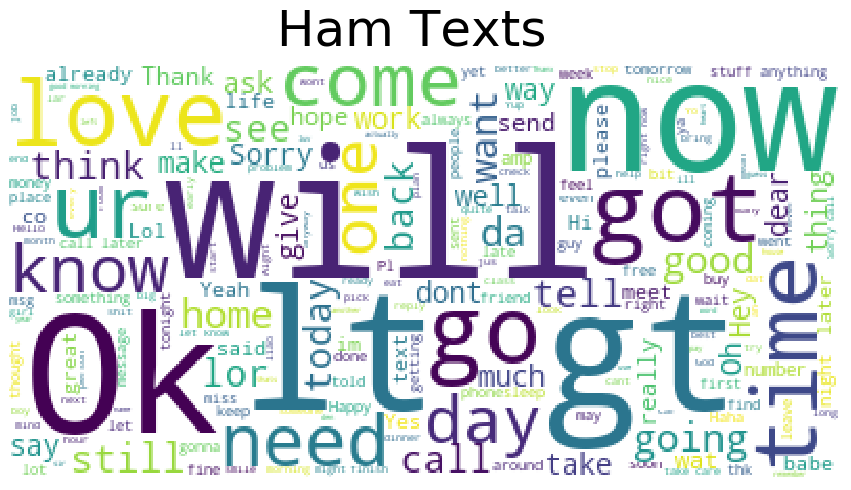

In [39]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white', random_state=1).generate(ham_words)

plt.imshow(img)
plt.axis('off')

plt.figtext(.5,.9,'Ham Texts', fontsize=50, ha='center')
plt.show()

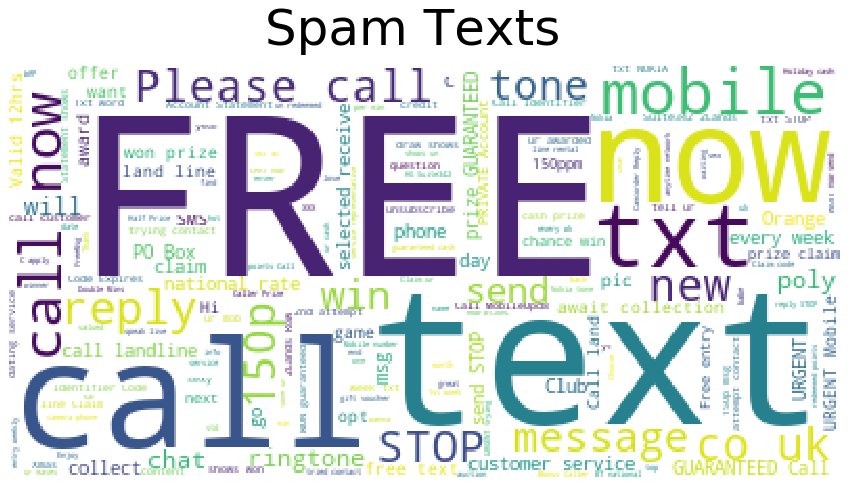

In [40]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white', random_state=1).generate(spam_words)

plt.imshow(img)
plt.axis('off')

plt.figtext(.5,.9,'Spam Texts', fontsize=50, ha='center')
plt.show()